In [70]:
# Parameters
artificial_humans = "../../data/training/ah_11/data/model.pt"
artificial_humans_model = "graph"
output_file = "../../data/manager/simulate_rule/v1/data.pt"
n_episode_steps = 16
grid = {
    "s": {"start": 0, "stop": 2, "num": 11},
    "b": {"start": 0, "stop": 5, "num": 11},
    "c": {"start": 0, "stop": 2, "num": 5},
}
n_episodes = 4


In [71]:
%load_ext autoreload
%autoreload 2

import torch as th
import numpy as np
import seaborn as sns
from itertools import count
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv
from aimanager.artificial_humans import AH_MODELS
from aimanager.utils.array_to_df import using_multiindex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
class RuleManager:
    def __init__(self, s, b, c):
        self.s = s
        self.b = b
        self.c = c

    def get_punishment(self, contributions, **_):
        punishments = (20-contributions) * self.s + (20 != contributions).to(th.float) * self.c - self.b
        punishments = punishments.round().to(th.int64)
        punishments = th.minimum(th.maximum(punishments, th.zeros_like(punishments)), th.full_like(punishments, 30))
        return punishments

In [73]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = AH_MODELS[artificial_humans_model].load(artificial_humans).to(device)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, episode_steps=n_episode_steps, device=device)

total_episodes = grid['s']['num'] * grid['b']['num'] * grid['c']['num'] * n_episodes

recorder = Memory(n_episodes=total_episodes, n_episode_steps=n_episode_steps, output_file=output_file, device=device)


for s in np.linspace(**grid['s']):
    for b in np.linspace(**grid['b']):
        for c in np.linspace(**grid['c']):
            for episode in range(n_episodes):
                manager = RuleManager(s=s, b=b, c=c)
                state = env.init_episode()
                for step in count():
                    action = manager.get_punishment(**state)
                    state = env.punish(action)
                    state, reward, done = env.step()
                    recorder.add(**state, s=th.tensor(s), b=th.tensor(b), c=th.tensor(c), episode_step=step)
                    if done:
                        break
                recorder.next_episode(episode)

In [74]:
prev_punishments = using_multiindex(recorder.memory['prev_punishments'].numpy(), columns=['idx','round_number', 'agent'], value_name='prev_punishments')
prev_common_good = using_multiindex(recorder.memory['prev_common_good'].numpy(), columns=['idx','round_number', 'agent'], value_name='prev_common_good')
prev_contributions = using_multiindex(recorder.memory['prev_contributions'].numpy(), columns=['idx','round_number', 'agent'], value_name='prev_contributions')
contributions = using_multiindex(recorder.memory['contributions'].numpy(), columns=['idx','round_number', 'agent'], value_name='contributions')
s = using_multiindex(recorder.memory['s'].numpy(), columns=['idx','round_number'], value_name='s')
b = using_multiindex(recorder.memory['b'].numpy(), columns=['idx','round_number'], value_name='b')
c = using_multiindex(recorder.memory['c'].numpy(), columns=['idx','round_number'], value_name='c')
contributions = using_multiindex(recorder.memory['contributions'].numpy(), columns=['idx','round_number', 'agent'], value_name='contributions')


df = prev_punishments.merge(prev_common_good).merge(prev_contributions).merge(contributions).merge(s).merge(b).merge(c).merge(contributions)

In [81]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].mean()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm, xticklabels=cm.columns.values.round(2), yticklabels=cm.index.values.round(2))

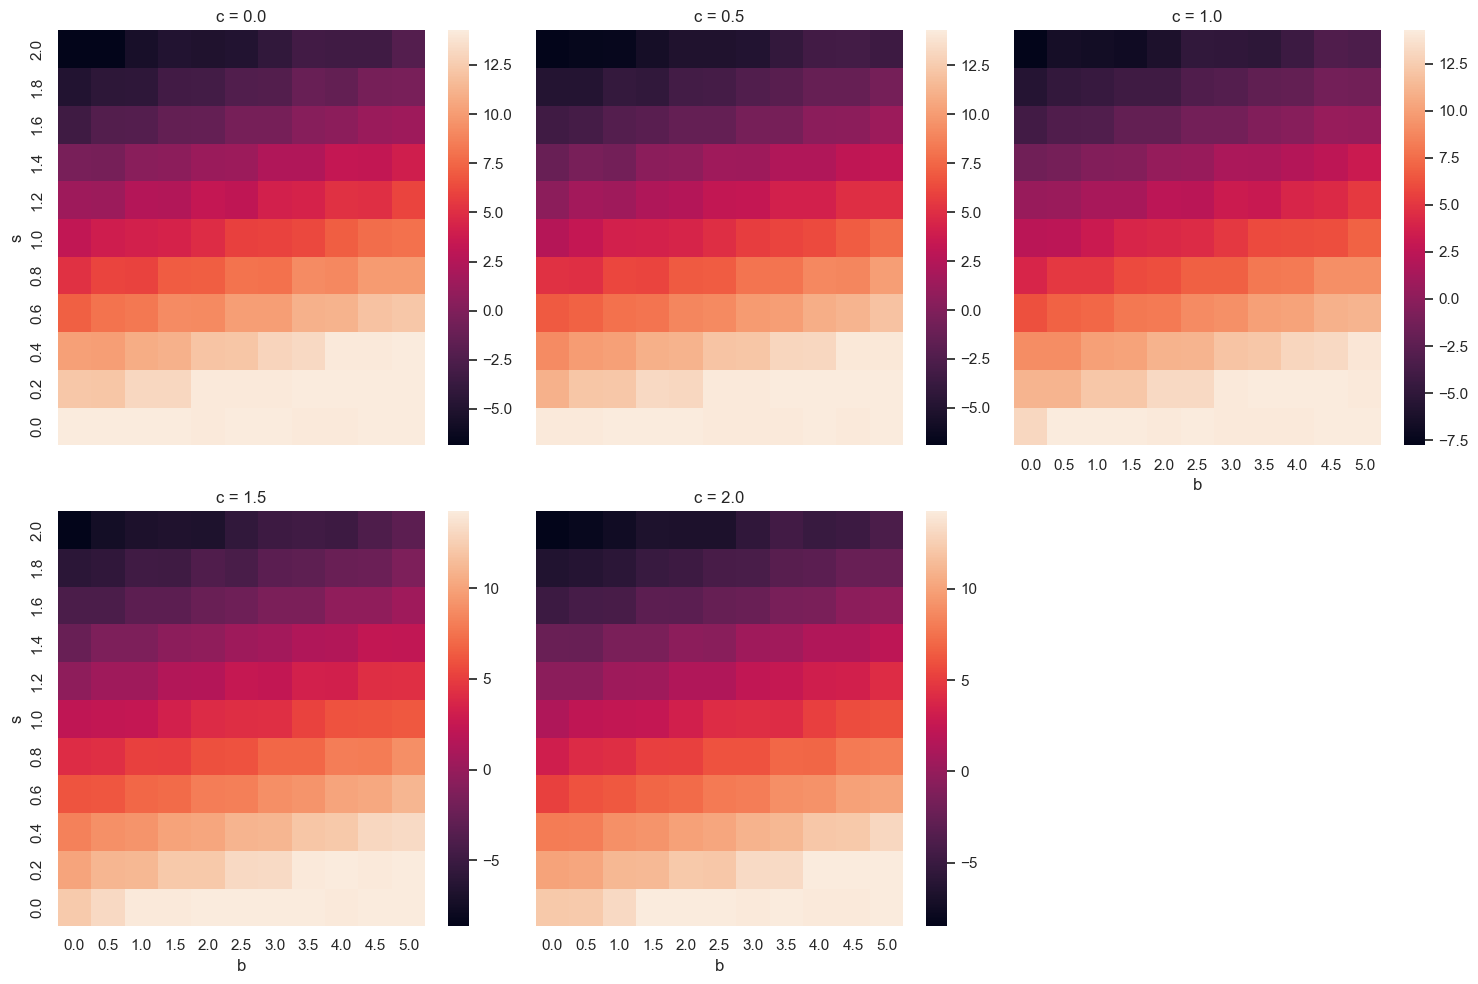

In [82]:
plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='s', y='b', normalise=False, values='prev_common_good')

fg = sns.FacetGrid(
    df, col='c',
    col_wrap=3,
    height=5)
fg.map_dataframe(plot_heatmap)

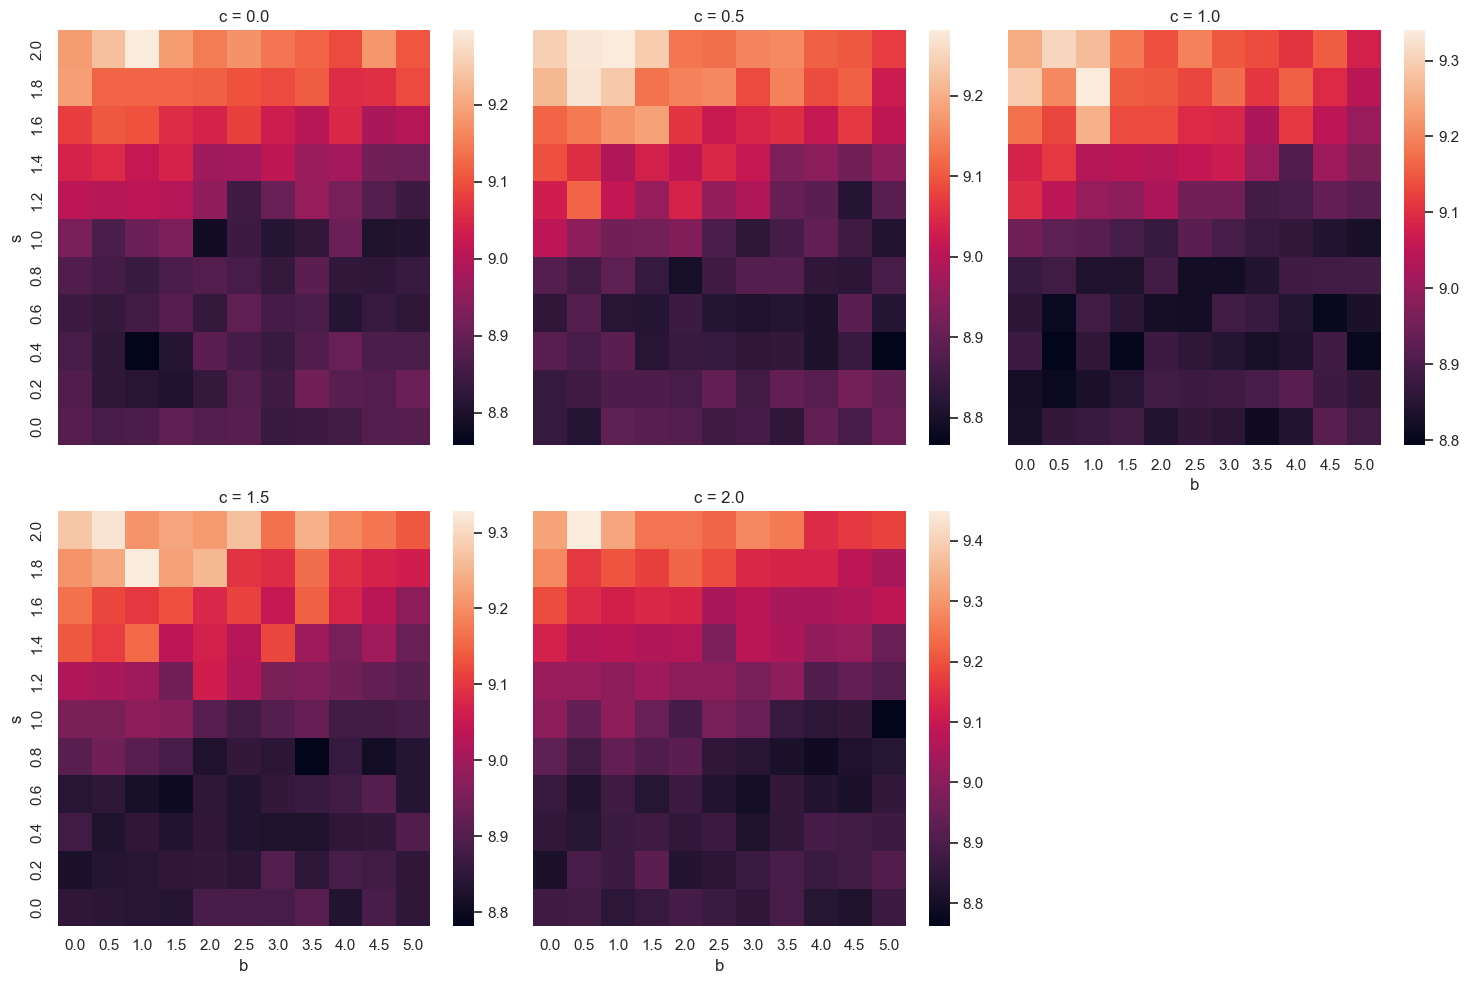

In [83]:

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='s', y='b', normalise=False, values='contributions')

fg = sns.FacetGrid(
    df, col='c',
    col_wrap=3,
    height=5)
fg.map_dataframe(plot_heatmap)

<AxesSubplot:xlabel='round_number', ylabel='contributions'>

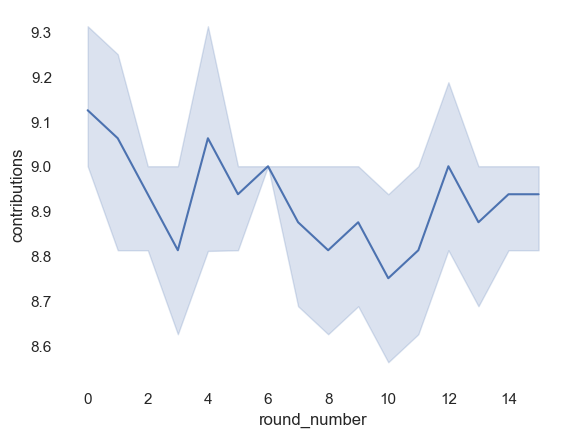

In [87]:
w = (
    (df['s'] == 1) &
    (df['b'] == 0) &
    (df['c'] == 0)
)

dfs = df[w].copy()
sns.lineplot(data=dfs, x='round_number', y='contributions')

<AxesSubplot:xlabel='round_number', ylabel='count'>

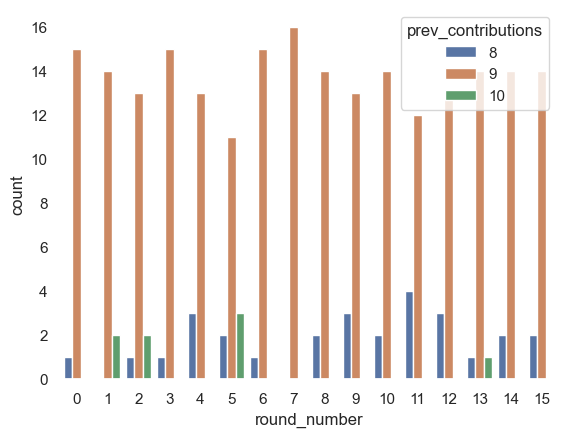

In [92]:
w = (
    (df['s'] == 1) &
    (df['b'] == 0) &
    (df['c'] == 0)
)

dfs = df[w].copy()
sns.countplot(data=dfs, hue='prev_contributions', x='round_number')

In [90]:
df

,idx,round_number,agent,prev_punishments,prev_common_good,prev_contributions,contributions,s,b,c
0,0,0,0,0,14.400001,9,9,0.0,0.0,0.0
1,0,0,1,0,12.800000,8,9,0.0,0.0,0.0
2,0,0,2,0,14.400001,9,9,0.0,0.0,0.0
3,0,0,3,0,14.400001,9,9,0.0,0.0,0.0
4,0,1,0,0,14.400001,9,9,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
154875,2419,14,3,19,-4.599999,9,9,2.0,5.0,2.0
154876,2419,15,0,19,-4.599999,9,9,2.0,5.0,2.0
154877,2419,15,1,19,-4.599999,9,9,2.0,5.0,2.0
154878,2419,15,2,21,-8.200000,8,9,2.0,5.0,2.0
